This notebook characterizes the dependence of sequence replay on specific model parameter combinations.

In [1]:
%reset -f
%matplotlib inline
from ast import literal_eval
from copy import deepcopy as copy
from itertools import product as cprod
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, ndimage

from aux import lognormal_mu_sig, sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from ntwk import LIFNtwk, join_w
from replay import cxn, smln

cc = np.concatenate


N_SEEDS = 10
MAX_SEED = 1000
DTCN_WDW = .1
TRJ_CUTOFF = .75
NTRJ_CUTOFF = .5
RANK_CORR_CUTOFF = .9

# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .024, 'L_PC_PC': 0.066, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,  # unused
    'W_INH_PC': 0., 'W_PC_INH': 0.,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.008, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": .8},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

# Plot saved results

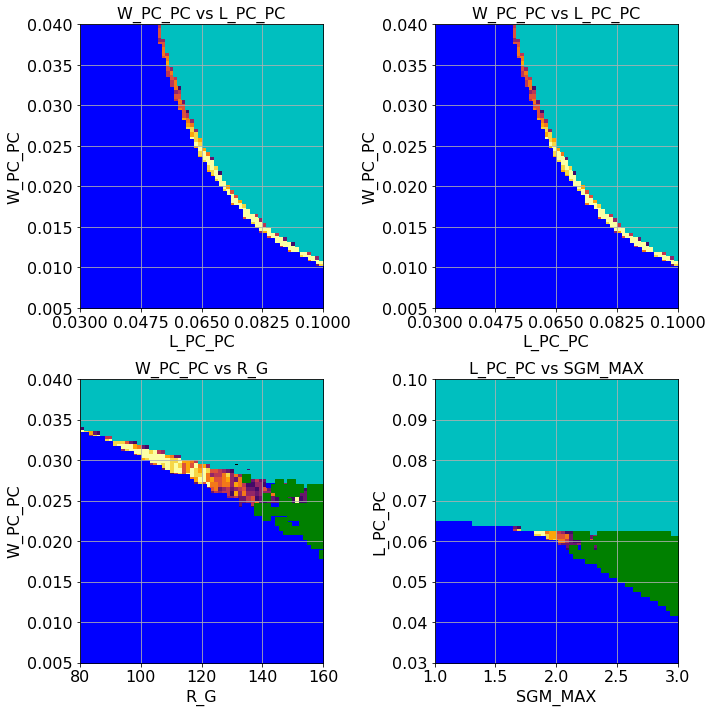

In [2]:
RSLT_FILES = [
    'dense_n_replay_param_sweep_L_PC_PC_W_PC_PC_0.csv',
    'dense_n_replay_param_sweep_L_PC_PC_W_PC_PC_1.csv',
    'dense_n_replay_param_sweep_R_G_W_PC_PC_0.csv',
    'dense_n_replay_param_sweep_SGM_MAX_L_PC_PC_0.csv',
]

m_paramss = []
s_paramss = []
cols = []
dfs = []

fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

for rslt_file, ax in zip(RSLT_FILES, axs.flatten()):
    
    with open(rslt_file, 'r') as f:
        m_params = literal_eval(f.readline().strip())
        s_params = literal_eval(f.readline().strip())

    df = pd.read_csv(rslt_file, header=2, index_col=0)

    col_x = df.columns[1]
    col_y = df.columns[2]
    
    vals_x = df[col_x]
    vals_y = df[col_y]
    
    n_replay = df['N_REPLAY']
    
    ax.scatter(vals_x, vals_y, marker='s', s=55, c=n_replay, cmap='inferno', vmin=0, vmax=10, lw=0, zorder=0)
    
    # color non-replay units by fadeout vs blowup vs disordered
    df_fadeout = df[(n_replay < 2) & (df['N_FADEOUT'] > df['N_BLOWUP']) & (df['N_FADEOUT'] > df['N_DISORDERED'])]
    ax.scatter(df_fadeout[col_x], df_fadeout[col_y], marker='s', s=55, c='b', zorder=1)
    
    df_blowup = df[(n_replay < 2) & (df['N_BLOWUP'] > df['N_FADEOUT']) & (df['N_BLOWUP'] > df['N_DISORDERED'])]
    ax.scatter(df_blowup[col_x], df_blowup[col_y], marker='s', s=55, c='c', zorder=1)
    
    df_disordered = df[(n_replay < 2) & (df['N_DISORDERED'] > df['N_BLOWUP']) & (df['N_DISORDERED'] > df['N_FADEOUT'])]
    ax.scatter(df_disordered[col_x], df_disordered[col_y], marker='s', s=55, c='g', zorder=1)
    
    ax.set_xlim(vals_x.min(), vals_x.max())
    ax.set_ylim(vals_y.min(), vals_y.max())
    
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.set_title('{} vs {}'.format(col_y, col_x))
    
    ax.grid()
    
    set_font_size(ax, 16)
    set_n_x_ticks(ax, 5)
    
    m_paramss.append(m_params)
    s_paramss.append(s_params)
    
    cols.append((col_x, col_y))
    
    dfs.append(df)

## Define fadeout, blowup, and replay, detection functions

In [3]:
def detect_rsp_type(rslt, m_params, s_params):
    # get mask over trj and non-trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & mask_pc
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    
    # get spk cts in for trj/non-trj cells during detection wdw
    spks_trj = rslt.spks[t_mask][:, trj_mask]
    spks_ntrj = rslt.spks[t_mask][:, ntrj_mask]
    
    # get frac of trj/non-trj cells that spikes
    p_spk_trj = np.mean(spks_trj.sum(0) > 0)
    p_spk_ntrj = np.mean(spks_ntrj.sum(0) > 0)
    
    # check if fadeout or blowup
    if p_spk_trj < TRJ_CUTOFF:
        return 'fadeout'
    elif p_spk_ntrj >= NTRJ_CUTOFF:
        return 'blowup'
    
    # check if replay is ordered or not
    ## get mask over spking trj cells
    trj_spk_mask = trj_mask & (rslt.spks[t_mask].sum(0) > 0.5)
    
    ## order nrns by place field location along trj
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    ### negative b/c trj is triggered to replay in reverse
    pf_order = -smln.dist_to_trj(pfxs[trj_spk_mask], pfys[trj_spk_mask], rslt.trj['x'], rslt.trj['y'])[1]
    
    ## order nrns by first spk times
    spk_order = rslt.spks[t_mask][:, trj_spk_mask].argmax(0)
    
    ## get correlation
    pf_spk_rank_corr = stats.spearmanr(pf_order, spk_order)[0]
    
    if pf_spk_rank_corr < RANK_CORR_CUTOFF:
        return 'disordered'
    else:
        return 'replay'

## Connectivity functions

In [4]:
def make_w_inh_pc(pfxs_inh, pfys_inh, pfxs_pc, pfys_pc, p):
    """
    Make proximally biased PC->INH weight matrix.
    """
    n_inh = p['N_INH']
    n_pc = p['N_PC']
    
    # build weight matrix
    w_inh_pc = p['W_INH_PC'] * (np.random.rand(n_inh, n_pc) < 0.5).astype(float)
    return w_inh_pc
    
    
def make_w_pc_inh(pfxs_pc, pfys_pc, pfxs_inh, pfys_inh, p):
    """
    Make center-surround structured INH->PC weight matrix.
    """
    n_pc = p['N_PC']
    n_inh = p['N_INH']
    
    # build weight matrix
    w_pc_inh = p['W_PC_INH'] * (np.random.rand(n_pc, n_inh) < 0.5).astype(float)
    return w_pc_inh


def make_v_th_inh(p):
    
    return np.repeat(p['V_TH_INH'], p['N_INH'])

## Simulation functions

In [5]:
def build_ntwk(p, s_params):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s_params['RNG_SEED'])
    
    # set membrane properties
    n = p['N_PC'] + p['N_INH']
    
    t_m = cc(
        [np.repeat(p['T_M_PC'], p['N_PC']), np.repeat(p['T_M_INH'], p['N_INH'])])
    e_l = cc(
        [np.repeat(p['E_L_PC'], p['N_PC']), np.repeat(p['E_L_INH'], p['N_INH'])])
    v_th = cc(
        [np.repeat(p['V_TH_PC'], p['N_PC']), make_v_th_inh(p)])
    v_r = cc(
        [np.repeat(p['V_R_PC'], p['N_PC']), np.repeat(p['V_R_INH'], p['N_INH'])])
    t_rp = cc(
        [np.repeat(p['T_R_PC'], p['N_PC']), np.repeat(p['T_R_INH'], p['N_INH'])])
    
    # set latent nrn positions
    lb = [-s_params['BOX_W']/2, -s_params['BOX_H']/2]
    ub = [s_params['BOX_W']/2, s_params['BOX_H']/2]
    
    # sample evenly spaced place fields
    ## E cells
    pfxs_e, pfys_e = cxn.apx_lattice(lb, ub, p['N_PC'], randomize=True)
    ## I cells
    pfxs_i, pfys_i = cxn.apx_lattice(lb, ub, p['N_INH'], randomize=True)
    
    ## join E & I place fields
    pfxs = cc([pfxs_e, pfxs_i])
    pfys = cc([pfys_e, pfys_i])
    
    # make upstream ws
    if p['W_PC_PL'] > 0:
        w_pc_pl_flat = np.random.lognormal(
            *lognormal_mu_sig(p['W_PC_PL'], p['S_PC_PL']), p['N_PC'])
    else:
        w_pc_pl_flat = np.zeros(p['N_PC'])
    
    if p['W_PC_G'] > 0:
        w_pc_g_flat = np.random.lognormal(
            *lognormal_mu_sig(p['W_PC_G'], p['S_PC_G']), p['N_PC'])
    else:
        w_pc_g_flat = np.zeros(p['N_PC'])
    
    ws_up_temp = {
        'E': {
            ('PC', 'PL'): np.diag(w_pc_pl_flat),
            ('PC', 'G'): np.diag(w_pc_g_flat),
        },
    }
    
    targs_up = cc([np.repeat('PC', p['N_PC']), np.repeat('INH', p['N_INH'])])
    srcs_up = cc([np.repeat('PL', p['N_PC']), np.repeat('G', p['N_PC'])])
    
    ws_up = join_w(targs_up, srcs_up, ws_up_temp)
    
    # make rcr ws
    w_pc_pc = cxn.make_w_pc_pc(pfxs[:p['N_PC']], pfys[:p['N_PC']], p)
    
    w_inh_pc = make_w_inh_pc(
        pfxs_inh=pfxs[-p['N_INH']:],
        pfys_inh=pfys[-p['N_INH']:],
        pfxs_pc=pfxs[:p['N_PC']],
        pfys_pc=pfys[:p['N_PC']],
        p=p)
    
    w_pc_inh = make_w_pc_inh(
        pfxs_pc=pfxs[:p['N_PC']],
        pfys_pc=pfys[:p['N_PC']],
        pfxs_inh=pfxs[-p['N_INH']:],
        pfys_inh=pfys[-p['N_INH']:],
        p=p)
    
    ws_rcr_temp = {
        'E': {
            ('PC', 'PC'): w_pc_pc,
            ('INH', 'PC'): w_inh_pc,
        },
        'I': {
            ('PC', 'INH'): w_pc_inh,
        },
    }
    targs_rcr = cc([np.repeat('PC', p['N_PC']), np.repeat('INH', p['N_INH'])])
    
    ws_rcr = join_w(targs_rcr, targs_rcr, ws_rcr_temp)
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=t_m,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_rp,
        es_syn={'E': p['E_E'], 'I': p['E_I']},
        ts_syn={'E': p['T_E'], 'I': p['T_I']},
        ws_up=ws_up,
        ws_rcr=ws_rcr)
    
    ntwk.pfxs = pfxs
    ntwk.pfys = pfys
    
    ntwk.types_up = srcs_up
    ntwk.types_rcr = targs_rcr
    
    ntwk.n_pc = p['N_PC']
    ntwk.n_inh = p['N_INH']
    ntwk.n_g = p['N_PC']
    ntwk.n_inp = p['N_PC']
    ntwk.n_rcr = p['N_PC'] + p['N_INH']
    ntwk.n_up = 2 * p['N_PC']
    
    ntwk.types_up_slc = {
        'PL': slice(0, p['N_PC']),
        'G': slice(p['N_PC'], 2*p['N_PC'])
    }
    ntwk.types_rcr_slc = {
        'PC': slice(0, p['N_PC']),
        'INH': slice(p['N_PC'], p['N_PC'] + p['N_INH'])
    }
    
    return ntwk


def run(p, s_params):
    """
    Run smln and return rslt.
    
    :param p: dict of model params
    :param s_params: dict of smln params
    """
    # prepare smln
    prep_start = time.time()
    
    ## build trajectory
    trj = smln.build_trj(s_params)
    schedule = s_params['schedule']
    
    ## adjust schedule
    t = np.arange(0, schedule['D_SMLN'], s_params['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(p, s_params)
    
    ## get apx. real-valued mask ("veil") over trj nrns;
    ## values are >= 0 and correspond to apx. scale factors on
    ## corresponding G->PC weights minus 1
    trj_veil = smln.get_trj_veil(trj, ntwk, p, s_params)
    ntwk.sgm = trj_veil + 1
    
    ## approximate G->PC weights if desired
    ntwk = smln.apx_ws_up(ntwk, trj_veil)
        
    spks_up, i_ext = smln.build_stim(t, trj, ntwk, p, s_params, schedule)
    
    prep_end = time.time()
    prep_time = prep_end - prep_start
    
    # run smln
    run_start = time.time()
    
    rslt = ntwk.run(spks_up=spks_up, dt=s_params['DT'], i_ext=i_ext)
    run_end = time.time()
    
    run_time = run_end - run_start
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.schedule = schedule
    rslt.trg = s_params['TRG']
    
    rslt.p = p
    rslt.s_params = s_params
    
    rslt.trj = trj
    rslt.trj_veil = trj_veil
    
    metrics, success = smln.get_metrics(rslt, s_params)
    
    rslt.metrics = metrics
    rslt.success = success
    
    rslt.prep_time = prep_time
    rslt.run_time = run_time
   
    return rslt

## Plotting function for INH population

In [6]:
from scipy.ndimage import gaussian_filter1d as smooth

def plot_inh(rslt, smoothness=1):
    fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, tight_layout=True)
    
    # get spks
    spks_inh = rslt.spks[:, -rslt.p['N_INH']:]
    
    # raster
    t_idxs_spks_inh, nrn_spks_inh = spks_inh.nonzero()
    t_spks_inh = t_idxs_spks_inh * rslt.dt
    
    axs[0].scatter(t_spks_inh, nrn_spks_inh, s=5, c='r')
    axs[0].set_ylim(-1, rslt.p['N_INH'])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Neuron')
    axs[0].set_title('Inhibitory activity')
    
    # inh population average
    axs[1].plot(rslt.ts, smooth(spks_inh.sum(axis=1) / (rslt.dt * rslt.p['N_INH']), smoothness), c='r', lw=3)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Average spike rate')
    
    for ax in axs:
        ax.set_xlim(0, rslt.ts[-1])
        set_font_size(ax, 16)
    
    return fig, axs

## PC plotting funcs

In [7]:
def plot_pc(rslt, smoothness=1):
    fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, tight_layout=True)
    
    # get spks
    spks_pc = rslt.spks[:, :rslt.p['N_PC']]
    
    # raster
    t_idxs_spks_pc, nrn_spks_pc = spks_pc.nonzero()
    t_spks_pc = t_idxs_spks_pc * rslt.dt
    
    axs[0].scatter(t_spks_pc, nrn_spks_pc, s=5, c='k')
    axs[0].set_ylim(-1, rslt.p['N_PC'])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Neuron')
    axs[0].set_title('PC activity')
    
    # inh population average
    axs[1].plot(rslt.ts, smooth(spks_pc.sum(axis=1) / (rslt.dt * rslt.p['N_PC']), smoothness), c='k', lw=3)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Average spike rate')
    
    for ax in axs:
        ax.set_xlim(0, rslt.ts[-1])
        set_font_size(ax, 16)
    
    return fig, axs


def get_idxs_nearest(xys, pfxs, pfys, nearest, colors):
    """
    Get ordered idxs of place fields nearest to a
    sequence of (x, y) points.
    """
    idxs = []
    c_dict_0 = {}
    c_dict_1 = []
    
    for xy, color in zip(xys, colors):
        # get dists of all PFs to (x, y)
        dx = pfxs - xy[0]
        dy = pfys - xy[1]
        d = np.sqrt(dx**2 + dy**2)
        
        # add idxs of closest neurons to list
        pcs = list(d.argsort()[:nearest])
        idxs.extend(pcs)
        
        for pc in pcs:
            c_dict_0[pc] = color
            
        c_dict_1.extend(len(pcs)*[color])
        
    return idxs, c_dict_0, np.array(c_dict_1)


def raster(rslt, xys, colors, cmap, nearest, epoch, trg_plt, y_lim, y_ticks, n_t_ticks=None, fig_size=(15, 4), title=None):
    """
    Generate a raster plot of spikes from a smln.
    
    :param xys: list of (x, y) locs to plot spks from nearby cells for
    :param nearest: # of cells per (x, y)
    :param epoch: 'replay', 'wdw', 'trj', or 'full', specifying which epoch
        to make raster for (replay, detection window, trajectory, or full smln)
    """
    # get ordered idxs of PCs to plot
    ## get pfs
    pc_mask = rslt.ntwk.types_rcr == 'PC'
    pfxs = rslt.ntwk.pfxs[pc_mask]
    pfys = rslt.ntwk.pfys[pc_mask]
    
    ## loop through (x, y) pairs and add idxs of nearest PCs
    ### pc_c_dict_0 uses original pc idxs, pc_c_dict_1 uses simplified pc idxs
    pc_idxs, pc_c_dict_0, pc_c_dict_1 = get_idxs_nearest(xys, pfxs, pfys, nearest, colors) 
    
    # get all spks for selected PCs
    spks_pc_chosen = rslt.spks[:, pc_idxs]
    
    # get desired time window
    if epoch == 'replay':
        start = 0
        end = rslt.schedule['D_SMLN']
    elif isinstance(epoch, tuple):
        start = epoch[0]
        end = epoch[1]
    
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    t_start = rslt.ts[t_mask][0]
    
    spk_t_idxs, pcs = spks_pc_chosen[t_mask].nonzero()
    spk_ts = spk_t_idxs * rslt.s_params['DT'] + t_start
    
    # make plots
    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    
    ## spks
    c = [pc_c_dict_1[pc] for pc in pcs]
    ax.scatter(spk_ts, pcs, c=c, s=30, vmin=0, vmax=1, cmap=cmap, lw=.5, edgecolor='k')
    
    ## replay trigger
    for trg, (y, marker) in zip(rslt.trg, trg_plt):
        ax.scatter(trg['T'], y, marker=marker, s=100, c='k')
    
    ax.set_xlim(start, end)
    ax.set_ylim(y_lim)
    ax.set_yticks(y_ticks)
    
    if n_t_ticks is not None:
        set_n_x_ticks(ax_0, n_t_ticks)
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('Neuron')
    if title is not None:
        ax.set_title(title)
    
    ax.set_facecolor((.9, .9, .9))
    
    set_font_size(ax, 20)
        
    return fig, ax

## Functional replay with inhibition

Running smln...
Smln complete.
RSP TYPE:  fadeout


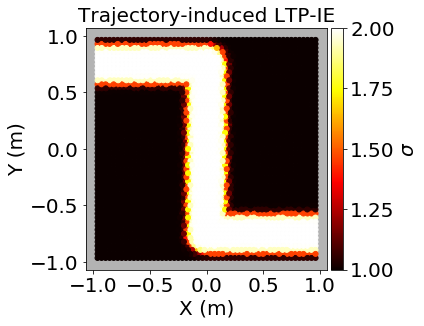

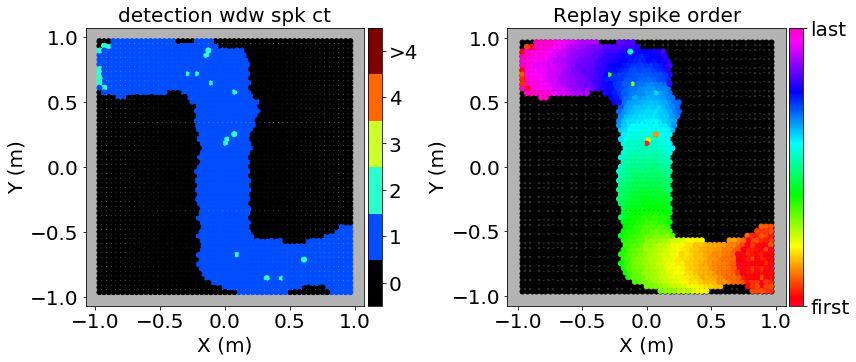

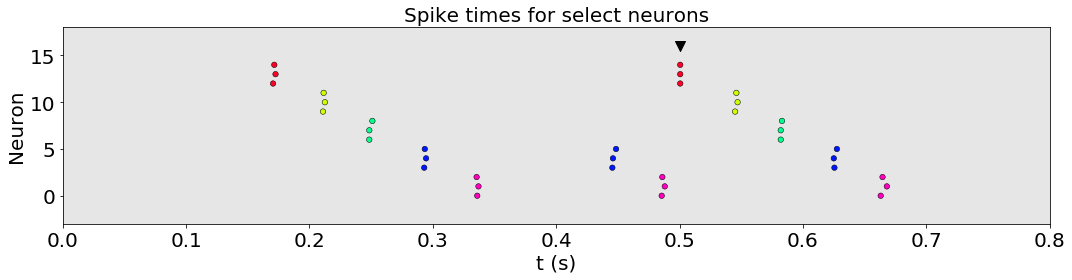

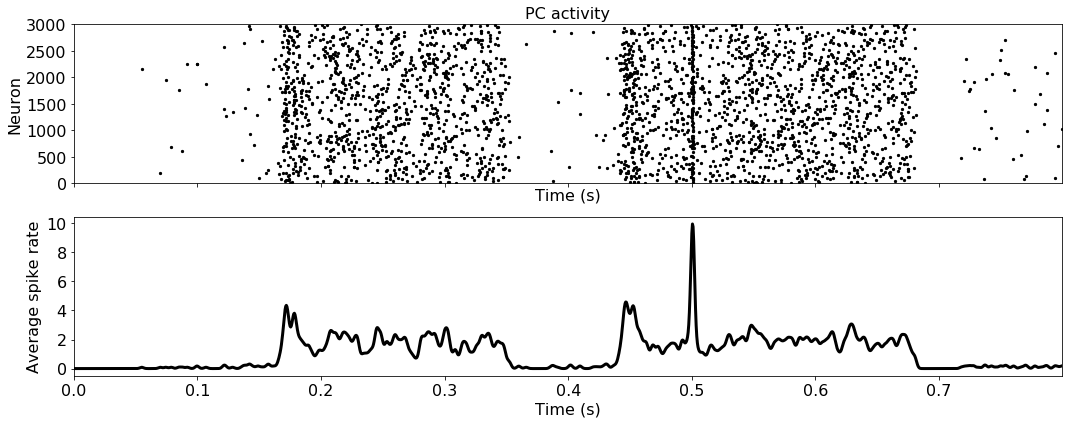

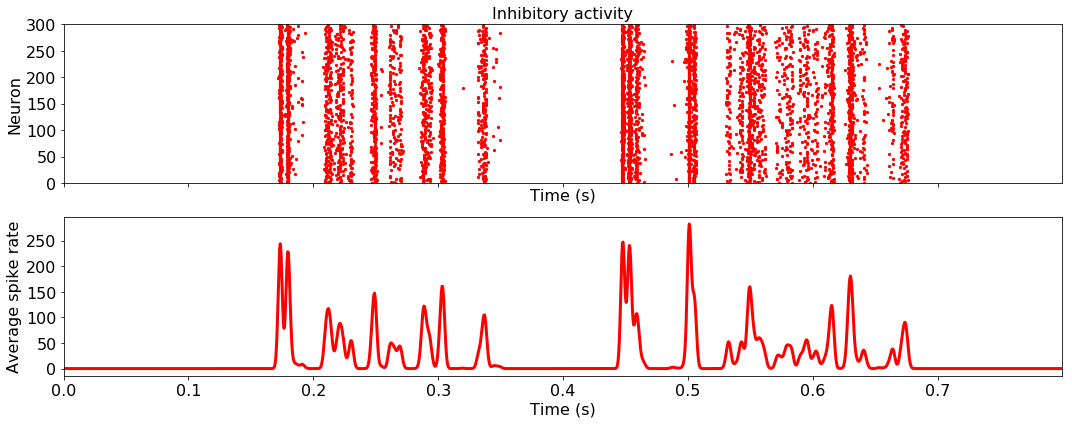

In [8]:
from replay import plot

m_params = copy(M_PARAMS)
m_params['W_PC_PC'] = .026
m_params['L_PC_PC'] = 0.053
m_params['W_INH_PC'] = 0.003
m_params['W_PC_INH'] = 0.0001

s_params = copy(S_PARAMS)
s_params['RNG_SEED'] = 1
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

print('Running smln...')
rslt = run(m_params, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(.5, .7));

raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons',
)

plot_pc(rslt, smoothness=3)

plot_inh(rslt, smoothness=3)

print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))